<a href="https://colab.research.google.com/github/Andy7204/CelebalTechAssignments/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔍 Tuning Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(



📊 Random Forest Classification Report:
              precision    recall  f1-score   support

       <=50K     0.8766    0.9463    0.9102      6803
        >50K     0.7854    0.5959    0.6777      2242

    accuracy                         0.8595      9045
   macro avg     0.8310    0.7711    0.7939      9045
weighted avg     0.8540    0.8595    0.8525      9045



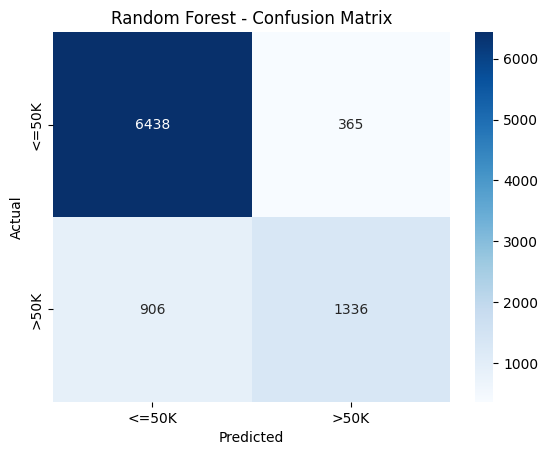


🔍 Tuning SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(



📊 SVM Classification Report:
              precision    recall  f1-score   support

       <=50K     0.8689    0.9333    0.8999      6803
        >50K     0.7388    0.5727    0.6452      2242

    accuracy                         0.8439      9045
   macro avg     0.8038    0.7530    0.7726      9045
weighted avg     0.8366    0.8439    0.8368      9045



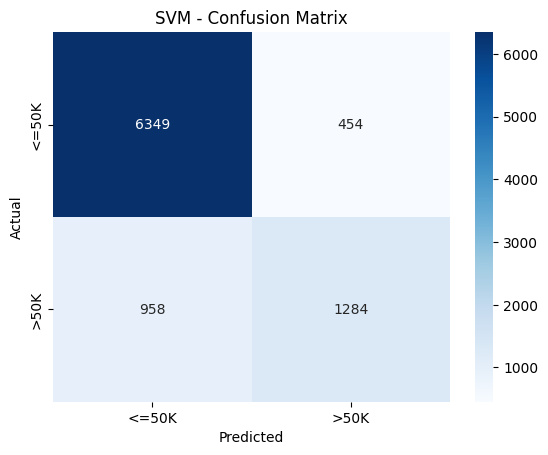


🔍 Tuning Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(



📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

       <=50K     0.8739    0.9289    0.9005      6803
        >50K     0.7332    0.5932    0.6558      2242

    accuracy                         0.8457      9045
   macro avg     0.8035    0.7610    0.7782      9045
weighted avg     0.8390    0.8457    0.8399      9045



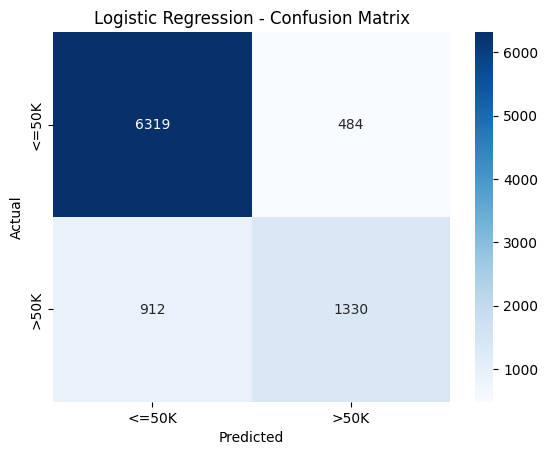


✅ Best Model: Random Forest with F1 Score: 0.6777

📝 Predictions saved to 'adult_predictions.csv'


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("adult.csv")
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Features & target
X = df.drop("income", axis=1)
y = df["income"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Model tuning spaces
search_spaces = {
    "Random Forest": {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
    },
    "SVM": {
        "classifier": [SVC()],
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf"],
        "classifier__gamma": ["scale", "auto"]
    },
    "Logistic Regression": {
        "classifier": [LogisticRegression(max_iter=1000)],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ["l2"],
        "classifier__solver": ["liblinear", "lbfgs"]
    }
}

# Store best models and results
best_models = {}
scores = {}

for model_name, param_grid in search_spaces.items():
    print(f"\n🔍 Tuning {model_name}...")

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", param_grid["classifier"][0])
    ])
    param_grid = {k: v for k, v in param_grid.items() if k != "classifier"}

    search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=5, cv=3,
                                scoring="f1", random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)

    best_models[model_name] = search.best_estimator_
    y_pred = search.best_estimator_.predict(X_test)

    print(f"\n📊 {model_name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred, labels=["<=50K", ">50K"])
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    scores[model_name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, pos_label=">50K"),
        "recall": recall_score(y_test, y_pred, pos_label=">50K"),
        "f1_score": f1_score(y_test, y_pred, pos_label=">50K"),
        "best_params": search.best_params_
    }

# Find best model based on F1-score
best_model_name = max(scores, key=lambda k: scores[k]["f1_score"])
best_model = best_models[best_model_name]
print(f"\n✅ Best Model: {best_model_name} with F1 Score: {scores[best_model_name]['f1_score']:.4f}")

# Predict on test set
final_preds = best_model.predict(X_test)

# Export to CSV
output = pd.DataFrame({
    "Actual": y_test,
    "Predicted": final_preds
})
output.to_csv("adult_predictions.csv", index=False)
print("\n📝 Predictions saved to 'adult_predictions.csv'")
